In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


from sklearn.datasets import make_blobs
from sklearn.metrics import f1_score,accuracy_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report
from sklearn.metrics import matthews_corrcoef,cohen_kappa_score,balanced_accuracy_score


import lightgbm as lgb
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

from modAL.models import ActiveLearner, Committee
from modAL.uncertainty import uncertainty_sampling
from functools import partial
from modAL.batch import uncertainty_batch_sampling

import warnings

warnings.filterwarnings('ignore')

In [2]:
float_id1 = '3901684'
float_id2 = '6901195'
float_id3 = '3901684'
data_source1="./dataset/PR_PF_"+float_id1+".csv"
data_source2="./dataset/PR_PF_"+float_id2+".csv"
data_source3="./dataset/PR_PF_"+float_id3+".csv"
df1= pd.read_csv(data_source1)
df2= pd.read_csv(data_source2)
df3= pd.read_csv(data_source3)
data=pd.concat([df1,df2,df3])
data

,Date,Latitude,longitude,Pressure,Salinity,Temperature,QC,label
0,-1.730828,0.107096,2.266649,-1.726008,1.953818,2.745999,0,0
1,-1.730828,0.107096,2.266649,-1.722558,1.953818,2.746051,0,0
2,-1.730828,0.107096,2.266649,-1.719125,1.953170,2.746051,0,0
3,-1.730828,0.107096,2.266649,-1.715604,1.953008,2.746121,0,0
4,-1.730828,0.107096,2.266649,-1.712171,1.953656,2.746190,0,0
...,...,...,...,...,...,...,...,...
149842,1.723431,0.987100,-0.978713,1.721038,-0.410773,-0.828686,0,0
149843,1.723431,0.987100,-0.978713,1.724454,-0.410935,-0.828842,0,0
149844,1.723431,0.987100,-0.978713,1.727869,-0.410935,-0.829206,0,0
149845,1.723431,0.987100,-0.978713,1.731425,-0.411259,-0.829744,0,0


In [3]:
row,col=data.shape

In [4]:
#def compute ratio
def comp_ratio(data):
    instance = data[(data['QC']==0)]
    rate=len(instance)/len(data)*100
    print(rate)
    return rate

In [5]:
dirty_ratio = 100-comp_ratio(data)
dirty_ratio

97.18535149849615


2.8146485015038536

In [6]:
data['QC'].unique()
# num_values = len()

array([0, 5, 4])

In [7]:
data.columns

Index(['Date', 'Latitude', 'longitude', 'Pressure', 'Salinity', 'Temperature',
       'QC', 'label'],
      dtype='object')

In [8]:
def plotCluster(data,name1,name2,name3,start,end):   
    %matplotlib notebook

    data1=data.loc[data['QC'] == 0]

    x1 = data1.loc[:,[name1]].iloc[start:end, :]  
    y1 = data1.loc[:,[name2]].iloc[start:end, :]  
    z1 = data1.loc[:,[name3]].iloc[start:end, :]  


    data2=data.loc[data['QC'] == 3]

    x2 = data2.loc[:,[name1]].iloc[start:end, :]  
    y2 = data2.loc[:,[name2]].iloc[start:end, :]  
    z2 = data2.loc[:,[name3]].iloc[start:end, :]  
    
    
    
    data3=data.loc[data['QC'] == 4]

    x3 = data3.loc[:,[name1]].iloc[start:end, :]  
    y3 = data3.loc[:,[name2]].iloc[start:end, :]  
    z3 = data3.loc[:,[name3]].iloc[start:end, :]  
    
    data4=data.loc[data['QC'] == 5]

    x4 = data4.loc[:,[name1]].iloc[start:end, :]  
    y4 = data4.loc[:,[name2]].iloc[start:end, :]  
    z4 = data4.loc[:,[name3]].iloc[start:end, :]  
    

    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    ax.scatter(x1, y1, z1, c='y',s=0.01, label='Normal Data')
    ax.scatter(x2, y2, z2, c='g',s=10, label='PRES')
    ax.scatter(x3, y3, z3, c='b',s=10, label='PSAL')
    ax.scatter(x4, y4, z4, c='r',s=10, label='TEMP')
    
    ax.legend(loc='best')

    ax.set_zlabel(name1, fontdict={'size': 15, 'color': 'black'})
    ax.set_ylabel(name2, fontdict={'size': 15, 'color': 'black'})
    ax.set_xlabel(name3, fontdict={'size': 15, 'color': 'black'})
    plt.show()
    plt.savefig('./image/'+float_cd+'_scatter.png')
    


In [9]:
# dataplot=data.copy()

# plotCluster(dataplot,"Temperature","Pressure","Salinity",0,data.shape[0])

# Splite Dataset

In [10]:
train1=pd.read_csv('./randomtrain/PR_PF_'+float_id1+'.csv') 
train2=pd.read_csv('./randomtrain/PR_PF_'+float_id2+'.csv') 
train3=pd.read_csv('./randomtrain/PR_PF_'+float_id3+'.csv') 
test1=pd.read_csv('./randomtest/PR_PF_'+float_id1+'.csv')
test2=pd.read_csv('./randomtest/PR_PF_'+float_id2+'.csv')
test3=pd.read_csv('./randomtest/PR_PF_'+float_id3+'.csv') 

train_set=pd.concat([train1,train2,train3])

test_set=pd.concat([test1,test2,test3])


len(train_set),len(test_set)

(215744, 92465)

In [11]:
comp_ratio(train_set)
comp_ratio(test_set)

97.18601676060517
97.18379927540151


97.18379927540151

In [12]:
#this function use random grid search to find best parameters
def getPar(model,dist,data,niter):
    import numpy as np
    import pandas as pd
    from sklearn.model_selection import RandomizedSearchCV
    x,y=data.shape

    clf = model

    param_dist = dist
    grid = RandomizedSearchCV(clf,param_dist,cv = 3,scoring = "balanced_accuracy",n_iter=niter,n_jobs = -1)

    #train
    grid.fit(data.iloc[:,0:y-1],data.iloc[:,y-1])
    #get best parameter
    print(grid.best_score_)
    return grid.best_params_

In [13]:
# metric
def computeMetric(y_tru,y_pre):
    acc = accuracy_score(y_tru,y_pre)
    pre=precision_score(y_tru,y_pre,average='macro')
    recall=recall_score(y_tru,y_pre,average='macro')
    cm=confusion_matrix(y_tru,y_pre)
    f1 = f1_score(y_tru,y_pre,average='macro')
    mcc=matthews_corrcoef(y_tru, y_pre)
    kappa=cohen_kappa_score(y_tru, y_pre)
    bac=balanced_accuracy_score(y_tru,y_pre)
    print("acc:",acc)
    print("precision:",pre)
    print("recall:",recall)
    print("cm:",cm)
    print("f1:",f1)
    print("balanced acc:",bac)
    print("MCC:", mcc)
    print("Kappa:",kappa)
    
    #confusion matrix
    cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
    plt.subplots(figsize=(12,8))
    cf_matrix = confusion_matrix(y_tru, y_pre)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})
    
    return f1

In [14]:
def draw(performance_history):
    fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
    ax.plot(performance_history)
    ax.scatter(range(len(performance_history)), performance_history, s=13)
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
    ax.set_ylim(bottom=0, top=1)
    ax.grid(True)
    ax.set_title('Incremental classification accuracy')
    ax.set_xlabel('Query iteration')
    ax.set_ylabel('Classification Accuracy')
    plt.show()

# splite train(pool), test, Labeled, Unlabeled

In [15]:
x,y=train_set.shape ##no qc
#pool 
X_Pool = train_set.iloc[:,0:y-2].values
y_Pool = train_set.iloc[:,y-1].values

In [16]:
#test set
X_test=test_set.iloc[:,0:y-2]
y_tru=test_set.iloc[:,y-1]
print(len(X_test),len(y_tru))

92465 92465


In [17]:
#Pool
def initial_data(n_initial,X_Pool,y_Pool):
    #inital
    initial_idx = np.random.choice(range(len(X_Pool)), size=n_initial, replace=False)
    #initial Labeled data
    #X_initial, y_initial = X_train[], y_train[initial_idx]
    X_L = X_Pool[initial_idx]
    y_L = y_Pool[initial_idx]
    # Unlabeled data
    # X_U = Pool_X[ini_num:]
    # y_U = Pool_X[ini_num:]
    X_U, y_U = np.delete(X_Pool, initial_idx, axis=0), np.delete(y_Pool, initial_idx, axis=0)
    return X_L,y_L,X_U,y_U

In [18]:
# Set RNG seed for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

n_initial= 100
#n_initial = 1000
N_QUERIES = 200 

In [19]:
X_initial,y_initial,X_re,y_re=initial_data(n_initial,X_Pool,y_Pool)
df_X_i = pd.DataFrame(X_initial)
df_y_i = pd.DataFrame(y_initial)
df_X_r = pd.DataFrame(X_re)
df_y_r = pd.DataFrame(y_re)




# X_initial1=pd.read_csv('./randomtrain/PR_PF_'+float_id1+'_X_initial.csv')
# X_initial2=pd.read_csv('./randomtrain/PR_PF_'+float_id2+'_X_initial.csv')
# X_initial3=pd.read_csv('./randomtrain/PR_PF_'+float_id3+'_X_initial.csv')

# y_initial1=pd.read_csv('./randomtrain/PR_PF_'+float_id1+'_y_initial.csv')
# y_initial2=pd.read_csv('./randomtrain/PR_PF_'+float_id2+'_y_initial.csv')
# y_initial3=pd.read_csv('./randomtrain/PR_PF_'+float_id3+'_y_initial.csv')


# X_initial=pd.concat([X_initial1,X_initial2,X_initial3])

# y_initial=pd.concat([y_initial1,y_initial2,y_initial3])

# X_initial=X_initial.values
# y_initial=y_initial.values.ravel()


In [20]:
# X_re1=pd.read_csv('./randomtrain/PR_PF_'+float_id1+'_X_re.csv')
# X_re2=pd.read_csv('./randomtrain/PR_PF_'+float_id2+'_X_re.csv')
# X_re3=pd.read_csv('./randomtrain/PR_PF_'+float_id3+'_X_re.csv')

# y_re1=pd.read_csv('./randomtrain/PR_PF_'+float_id1+'_y_re.csv')
# y_re2=pd.read_csv('./randomtrain/PR_PF_'+float_id2+'_y_re.csv')
# y_re3=pd.read_csv('./randomtrain/PR_PF_'+float_id3+'_y_re.csv')


# X_re=pd.concat([X_re1,X_re2,X_re3])

# y_re=pd.concat([y_re1,y_re2,y_re3])

# X_re=X_re.values
# y_re=y_re.values.ravel()



# # X_re=pd.read_csv('./randomtrain/'+float_cd+'_X_re.csv').values
# # y_re=pd.read_csv('./randomtrain/'+float_cd+'_y_re.csv').values.ravel()
# print(X_re.shape,X_initial.shape)
# print(y_re.shape,y_initial.shape)

In [21]:
# df_X_i.to_csv('./randomtrain/'+float_cd+'_X_initial.csv', index=False)
# df_y_i.to_csv('./randomtrain/'+float_cd+'_y_initial.csv', index=False)
# df_X_r.to_csv('./randomtrain/'+float_cd+'_X_re.csv', index=False)
# df_y_r.to_csv('./randomtrain/'+float_cd+'_y_re.csv', index=False)

# molAL

In [22]:
def random_sampling(classifier, X_pool):
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples))
    return query_idx, X_pool[query_idx]

In [23]:
def al(clf,strategy,X_L,y_L):
    learner = ActiveLearner(estimator=clf,
                            query_strategy=strategy,
                            X_training=X_L, y_training=y_L)
    return learner

In [24]:
def al_learn(clf,sampling,X_initial,y_initial,X_re,y_re):
    X_L = X_initial.copy()
    y_L = y_initial.copy()
    X_U,y_U =X_re.copy(),y_re.copy()
    #print(len(X_U),len(y_U))
    learner = al(clf,sampling,X_L,y_L)
    y_pre=learner.predict(X_test)
    unqueried_kappa=cohen_kappa_score(y_tru, y_pre)
    unqueried_f1=f1_score(y_tru,y_pre)
    #print("unqueried --------------------->",unqueried_score)
    kappa_history = [unqueried_kappa]
    f1_history = [unqueried_f1]
    y_L_2 = y_L.tolist()
    y_L_2 = np.array(y_L_2).reshape((-1, 1))
    queried_instance = np.concatenate((X_L, y_L_2), axis=1)

    # Query
    for index in range(N_QUERIES):
        query_index, query_instance = learner.query(X_U)
        # Teach ActiveLearner model the record it has requested.
        X, y = X_U[query_index].reshape(1, -1), y_U[query_index].reshape(1, )
        #print(X.flatten(), y)
        instance = np.concatenate((X.flatten(), y))
        #print(index+1,"query instance --------------------->",instance)
        learner.teach(X=X, y=y)
        
        X_U, y_U = np.delete(X_U, query_index, axis=0), np.delete(y_U, query_index)
        y_pre=learner.predict(X_test)
        kappa=cohen_kappa_score(y_tru, y_pre)
        f1=f1_score(y_tru,y_pre)
        print(index+1,"-------------------->",kappa)
        print(index+1,"-------------------->",f1)
        # Recall precision F1
        kappa_history.append(kappa)
        f1_history.append(f1)
        queried_instance = np.vstack((queried_instance, instance))

    #print(query_history)
    df_scores= pd.concat([pd.DataFrame(kappa_history,columns=['kappa']), 
                          pd.DataFrame(f1_history,columns=['f1'])],
                         axis=1)
    df_instance = pd.DataFrame(data=queried_instance, columns=['Date','Latitude','longitude','Pressure','Salinity','Temperature','Label'])
    #print(df_instance)
    return df_scores, df_instance 
#     return f1_history


1.0
{'n_neighbors': 1}
acc: 0.9993078462120802
precision: 0.993495964945576
recall: 0.9938640021281546
cm: [[89828    33]
 [   31  2573]]
f1: 0.9936799106992196
balanced acc: 0.9938640021281546
MCC: 0.9873598984810303
Kappa: 0.9873598214524372


0.9936799106992196

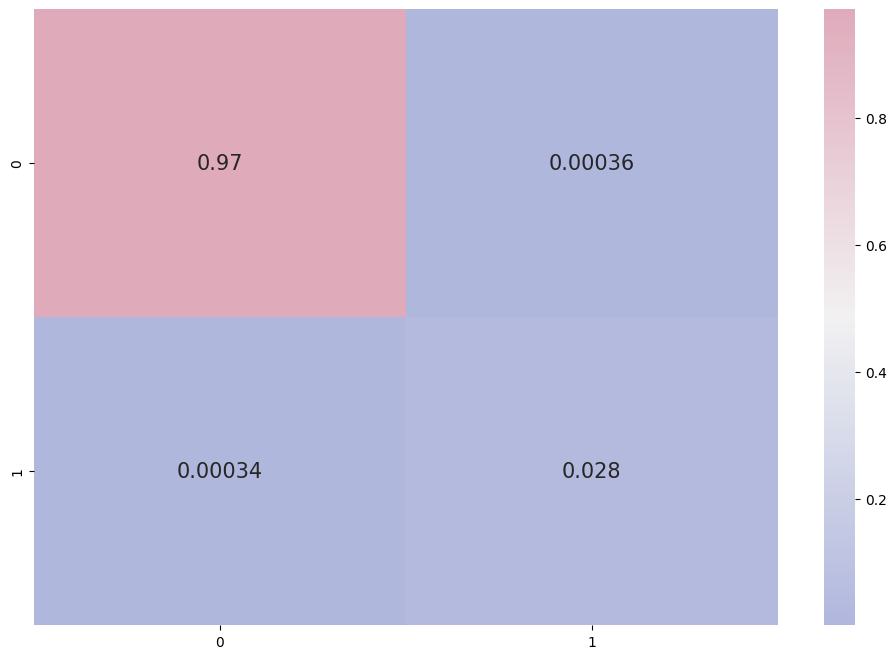

In [25]:
# clf1 KNN
clf1 = KNeighborsClassifier()
dic1={'n_neighbors':[1,2,3,4,5,6,7,8]}
para1=getPar(clf1,dic1,test_set,10)
print(para1)
clf1 = KNeighborsClassifier(n_neighbors=para1['n_neighbors'],n_jobs=-1)
clf1.fit(X_Pool, y_Pool)
y_pre=clf1.predict(X_test)
computeMetric(y_tru,y_pre)

1.0
acc: 0.9990266587357378
precision: 0.9932875793488061
recall: 0.9888716826197059
cm: [[89828    33]
 [   57  2547]]
f1: 0.9910690911681547
balanced acc: 0.9888716826197059
MCC: 0.9821493347381601
Kappa: 0.9821381933776964


0.9910690911681547

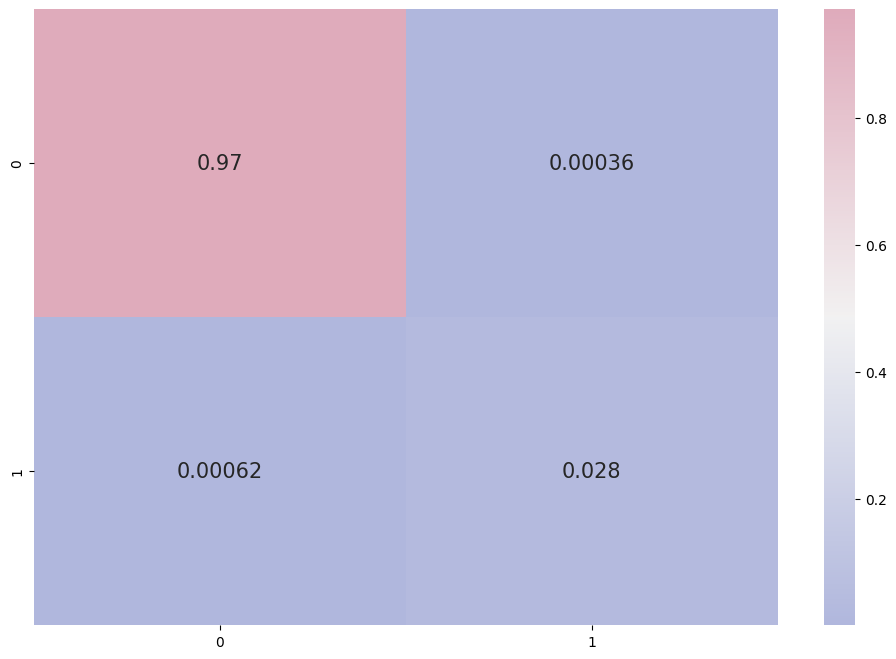

In [26]:
# clf2 lightgbm
clf2 = lgb.LGBMClassifier()

dic2 = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 900, 1000, 1500, 2000],
              'num_leaves': range(6, 50), 
              'min_child_samples': range(10, 200, 10), 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}
para2=getPar(clf2,dic2,test_set,10)

    
clf2 = lgb.LGBMClassifier(boosting_type='gbdt',
                          #objective='multiclass',
                          num_leaves=para2['num_leaves'], max_depth=-1, 
                              learning_rate=para2['learning_rate'], n_estimators=para2['n_estimators'], 
                              subsample_for_bin=200000, class_weight=None, min_split_gain=0.0, 
                              min_child_weight=para2['min_child_weight'],
                              min_child_samples=para2['min_child_samples'], 
                              subsample=1.0, 
                              subsample_freq=0, colsample_bytree=1.0, reg_alpha=para2['reg_alpha'], 
                              reg_lambda=para2['reg_lambda'], random_state=None, n_jobs=-1, importance_type='split')
clf2.fit(X_Pool, y_Pool)
y_pre=clf2.predict(X_test)
computeMetric(y_tru,y_pre)

1.0
acc: 0.9311739577137296
precision: 0.5045936009347932
recall: 0.5070460204359657
cm: [[85951  3910]
 [ 2454   150]]
f1: 0.5046592734229433
balanced acc: 0.5070460204359657
MCC: 0.01137833134712188
Kappa: 0.011083279662077117


0.5046592734229433

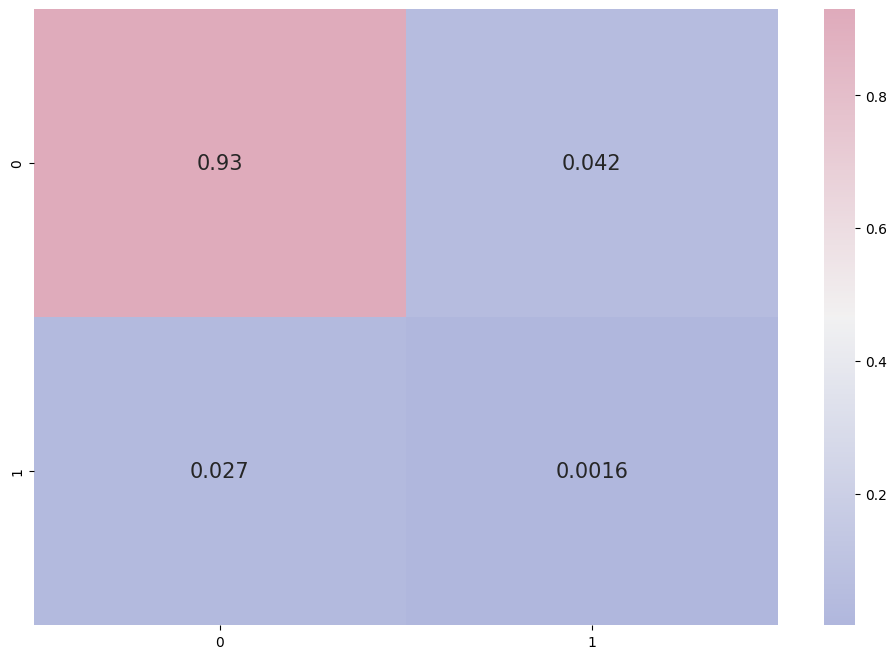

In [27]:
#XGBOOST
clf3 = xgb.XGBClassifier()
dic3 = {'n_estimators':range(80,2000,4),
        'max_depth':range(2,15,1),
        'learning_rate':np.linspace(0.01,2,20),
        'subsample':np.linspace(0.7,0.9,20),
        'colsample_bytree':np.linspace(0.5,0.98,10)
        }
para3=getPar(clf3,dic3,test_set,10)
clf3 = xgb.XGBClassifier(booster='gbtree',n_estimators=para3['n_estimators'], learning_rate=para3['learning_rate'],
                    max_depth=para3['max_depth'],subsample=para3['subsample'],
                    colsample_bytree=para3['colsample_bytree'],
                         #objective='multi:softprob',
                    n_jobs=-1)
clf3.fit(X_Pool, y_Pool)
y_pre=clf3.predict(X_test)
computeMetric(y_tru,y_pre)

Learning rate set to 0.102218
0:	learn: 0.3815356	total: 78.6ms	remaining: 1m 18s
1:	learn: 0.2015712	total: 98ms	remaining: 48.9s
2:	learn: 0.1101120	total: 116ms	remaining: 38.4s
3:	learn: 0.0657918	total: 135ms	remaining: 33.5s
4:	learn: 0.0406650	total: 255ms	remaining: 50.8s
5:	learn: 0.0271018	total: 286ms	remaining: 47.3s
6:	learn: 0.0188649	total: 303ms	remaining: 42.9s
7:	learn: 0.0120827	total: 320ms	remaining: 39.6s
8:	learn: 0.0094785	total: 336ms	remaining: 37s
9:	learn: 0.0077849	total: 352ms	remaining: 34.9s
10:	learn: 0.0066212	total: 368ms	remaining: 33.1s
11:	learn: 0.0059398	total: 384ms	remaining: 31.6s
12:	learn: 0.0054701	total: 399ms	remaining: 30.3s
13:	learn: 0.0049973	total: 415ms	remaining: 29.2s
14:	learn: 0.0045581	total: 431ms	remaining: 28.3s
15:	learn: 0.0043921	total: 447ms	remaining: 27.5s
16:	learn: 0.0042423	total: 464ms	remaining: 26.8s
17:	learn: 0.0040592	total: 482ms	remaining: 26.3s
18:	learn: 0.0038632	total: 499ms	remaining: 25.8s
19:	learn: 0

162:	learn: 0.0008059	total: 2.77s	remaining: 14.2s
163:	learn: 0.0008059	total: 2.79s	remaining: 14.2s
164:	learn: 0.0008059	total: 2.81s	remaining: 14.2s
165:	learn: 0.0008059	total: 2.82s	remaining: 14.2s
166:	learn: 0.0008059	total: 2.83s	remaining: 14.1s
167:	learn: 0.0008059	total: 2.85s	remaining: 14.1s
168:	learn: 0.0008059	total: 2.86s	remaining: 14.1s
169:	learn: 0.0008059	total: 2.87s	remaining: 14s
170:	learn: 0.0008059	total: 2.89s	remaining: 14s
171:	learn: 0.0008059	total: 2.9s	remaining: 14s
172:	learn: 0.0008059	total: 2.92s	remaining: 13.9s
173:	learn: 0.0008059	total: 2.93s	remaining: 13.9s
174:	learn: 0.0008059	total: 2.94s	remaining: 13.9s
175:	learn: 0.0008059	total: 2.95s	remaining: 13.8s
176:	learn: 0.0008059	total: 2.97s	remaining: 13.8s
177:	learn: 0.0008059	total: 2.98s	remaining: 13.8s
178:	learn: 0.0008059	total: 3s	remaining: 13.7s
179:	learn: 0.0008059	total: 3.01s	remaining: 13.7s
180:	learn: 0.0008059	total: 3.02s	remaining: 13.7s
181:	learn: 0.0008059	

329:	learn: 0.0008059	total: 5.04s	remaining: 10.2s
330:	learn: 0.0008059	total: 5.05s	remaining: 10.2s
331:	learn: 0.0008059	total: 5.07s	remaining: 10.2s
332:	learn: 0.0008059	total: 5.08s	remaining: 10.2s
333:	learn: 0.0008059	total: 5.09s	remaining: 10.2s
334:	learn: 0.0008059	total: 5.11s	remaining: 10.1s
335:	learn: 0.0008059	total: 5.12s	remaining: 10.1s
336:	learn: 0.0008059	total: 5.13s	remaining: 10.1s
337:	learn: 0.0008059	total: 5.14s	remaining: 10.1s
338:	learn: 0.0008059	total: 5.16s	remaining: 10.1s
339:	learn: 0.0008059	total: 5.17s	remaining: 10s
340:	learn: 0.0008059	total: 5.18s	remaining: 10s
341:	learn: 0.0008059	total: 5.19s	remaining: 9.99s
342:	learn: 0.0008059	total: 5.21s	remaining: 9.97s
343:	learn: 0.0008059	total: 5.22s	remaining: 9.95s
344:	learn: 0.0008059	total: 5.23s	remaining: 9.93s
345:	learn: 0.0008059	total: 5.24s	remaining: 9.91s
346:	learn: 0.0008059	total: 5.25s	remaining: 9.89s
347:	learn: 0.0008059	total: 5.27s	remaining: 9.87s
348:	learn: 0.00

489:	learn: 0.0008059	total: 7.1s	remaining: 7.39s
490:	learn: 0.0008059	total: 7.11s	remaining: 7.37s
491:	learn: 0.0008059	total: 7.13s	remaining: 7.36s
492:	learn: 0.0008059	total: 7.14s	remaining: 7.34s
493:	learn: 0.0008059	total: 7.15s	remaining: 7.33s
494:	learn: 0.0008059	total: 7.17s	remaining: 7.31s
495:	learn: 0.0008059	total: 7.18s	remaining: 7.29s
496:	learn: 0.0008059	total: 7.19s	remaining: 7.28s
497:	learn: 0.0008059	total: 7.21s	remaining: 7.26s
498:	learn: 0.0008059	total: 7.22s	remaining: 7.25s
499:	learn: 0.0008059	total: 7.23s	remaining: 7.23s
500:	learn: 0.0008059	total: 7.24s	remaining: 7.21s
501:	learn: 0.0008059	total: 7.26s	remaining: 7.2s
502:	learn: 0.0008059	total: 7.27s	remaining: 7.18s
503:	learn: 0.0008059	total: 7.28s	remaining: 7.17s
504:	learn: 0.0008059	total: 7.29s	remaining: 7.15s
505:	learn: 0.0008059	total: 7.31s	remaining: 7.14s
506:	learn: 0.0008059	total: 7.32s	remaining: 7.12s
507:	learn: 0.0008059	total: 7.34s	remaining: 7.11s
508:	learn: 0.

657:	learn: 0.0008059	total: 9.37s	remaining: 4.87s
658:	learn: 0.0008059	total: 9.38s	remaining: 4.86s
659:	learn: 0.0008059	total: 9.4s	remaining: 4.84s
660:	learn: 0.0008059	total: 9.41s	remaining: 4.83s
661:	learn: 0.0008059	total: 9.42s	remaining: 4.81s
662:	learn: 0.0008059	total: 9.44s	remaining: 4.8s
663:	learn: 0.0008059	total: 9.45s	remaining: 4.78s
664:	learn: 0.0008059	total: 9.46s	remaining: 4.77s
665:	learn: 0.0008059	total: 9.47s	remaining: 4.75s
666:	learn: 0.0008059	total: 9.49s	remaining: 4.74s
667:	learn: 0.0008059	total: 9.5s	remaining: 4.72s
668:	learn: 0.0008059	total: 9.51s	remaining: 4.71s
669:	learn: 0.0008059	total: 9.53s	remaining: 4.69s
670:	learn: 0.0008059	total: 9.54s	remaining: 4.68s
671:	learn: 0.0008059	total: 9.55s	remaining: 4.66s
672:	learn: 0.0008059	total: 9.56s	remaining: 4.65s
673:	learn: 0.0008059	total: 9.58s	remaining: 4.63s
674:	learn: 0.0008059	total: 9.59s	remaining: 4.62s
675:	learn: 0.0008059	total: 9.61s	remaining: 4.6s
676:	learn: 0.00

817:	learn: 0.0008059	total: 11.4s	remaining: 2.54s
818:	learn: 0.0008059	total: 11.5s	remaining: 2.53s
819:	learn: 0.0008059	total: 11.5s	remaining: 2.52s
820:	learn: 0.0008059	total: 11.5s	remaining: 2.5s
821:	learn: 0.0008059	total: 11.5s	remaining: 2.49s
822:	learn: 0.0008059	total: 11.5s	remaining: 2.47s
823:	learn: 0.0008059	total: 11.5s	remaining: 2.46s
824:	learn: 0.0008059	total: 11.5s	remaining: 2.44s
825:	learn: 0.0008059	total: 11.5s	remaining: 2.43s
826:	learn: 0.0008059	total: 11.6s	remaining: 2.42s
827:	learn: 0.0008059	total: 11.6s	remaining: 2.4s
828:	learn: 0.0008059	total: 11.6s	remaining: 2.39s
829:	learn: 0.0008059	total: 11.6s	remaining: 2.37s
830:	learn: 0.0008059	total: 11.6s	remaining: 2.36s
831:	learn: 0.0008059	total: 11.6s	remaining: 2.35s
832:	learn: 0.0008059	total: 11.6s	remaining: 2.33s
833:	learn: 0.0008059	total: 11.6s	remaining: 2.32s
834:	learn: 0.0008059	total: 11.7s	remaining: 2.3s
835:	learn: 0.0008059	total: 11.7s	remaining: 2.29s
836:	learn: 0.0

987:	learn: 0.0008059	total: 13.8s	remaining: 167ms
988:	learn: 0.0008059	total: 13.8s	remaining: 153ms
989:	learn: 0.0008059	total: 13.8s	remaining: 139ms
990:	learn: 0.0008059	total: 13.8s	remaining: 125ms
991:	learn: 0.0008059	total: 13.8s	remaining: 111ms
992:	learn: 0.0008059	total: 13.8s	remaining: 97.4ms
993:	learn: 0.0008059	total: 13.8s	remaining: 83.5ms
994:	learn: 0.0008059	total: 13.8s	remaining: 69.6ms
995:	learn: 0.0008059	total: 13.9s	remaining: 55.7ms
996:	learn: 0.0008059	total: 13.9s	remaining: 41.7ms
997:	learn: 0.0008059	total: 13.9s	remaining: 27.8ms
998:	learn: 0.0008059	total: 13.9s	remaining: 13.9ms
999:	learn: 0.0008059	total: 13.9s	remaining: 0us
acc: 0.9993402909208889
precision: 0.9966428979540258
recall: 0.9912704206194134
cm: [[89845    16]
 [   45  2559]]
f1: 0.9939411530396972
balanced acc: 0.9912704206194134
MCC: 0.987898710142935
Kappa: 0.9878823170264761


0.9939411530396972

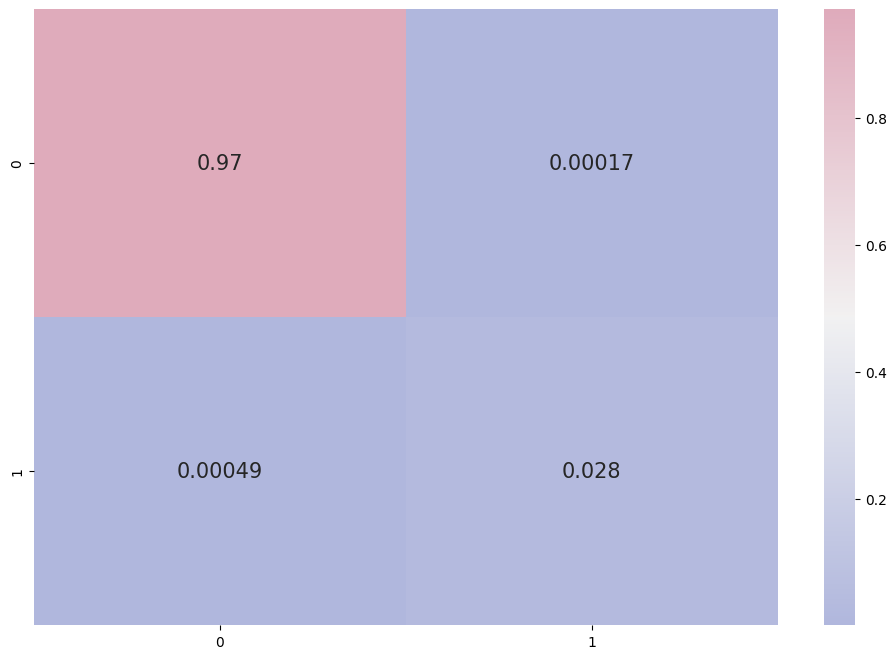

In [28]:
#clf4 catboost
clf4 = CatBoostClassifier(loss_function='Logloss')
# dic4 = {'learning_rate': [0.03, 0.1],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9]}
# #para3=getPar(clf4,dic4,test_set,10)

# grid_search_result = clf4.grid_search(dic4, 
#                                        X=X_Pool, 
#                                        y=y_Pool)

clf4.fit(X_Pool, y_Pool)
y_pre=clf4.predict(X_test)
computeMetric(y_tru,y_pre)

## random sampling

In [29]:
sampling=random_sampling

In [52]:
metric01,instance01 = al_learn(clf1,sampling,X_initial,y_initial,X_re,y_re)
instance01.to_csv("./query/random_Knn_"+"mix_ni"+".csv")

In [51]:
metric02,instance02 = al_learn(clf2,sampling,X_initial,y_initial,X_re,y_re)
instance02.to_csv("./query/random_Lg_"+"mix_ni"+".csv")

In [50]:
metric03,instance03= al_learn(clf3,sampling,X_initial,y_initial,X_re,y_re)
instance03.to_csv("./query/random_XB_"+"mix_ni"+".csv")

In [49]:
metric04,instance04= al_learn(clf4,sampling,X_initial,y_initial,X_re,y_re)
instance04.to_csv("./query/random_CB_"+"mix_ni"+".csv")

## Uncertainty

In [34]:
sampling=uncertainty_sampling

In [48]:
metric11,instance11 = al_learn(clf1,sampling,X_initial,y_initial,X_re,y_re)
instance11.to_csv("./query/Un_Knn_"+"mix_ni"+".csv")

In [47]:
metric12,instance12 = al_learn(clf2,sampling,X_initial,y_initial,X_re,y_re)
instance12.to_csv("./query/Un_Lg_"+"mix_ni"+".csv")

In [46]:
metric13,instance13 = al_learn(clf3,sampling,X_initial,y_initial,X_re,y_re)
instance13.to_csv("./query/Un_XB_"+"mix_ni"+".csv")

In [45]:
metric14,instance14 = al_learn(clf4,sampling,X_initial,y_initial,X_re,y_re)
instance14.to_csv("./query/Un_CB_"+"mix_ni"+".csv")

# save

In [39]:
def con_format(data):
    df = pd.DataFrame(data, columns=['Random_Knn_kappa', 'Random_Knn_F1','Random_Lightgbm_kappa','Random_Lightgbm_F1',
                                     "Random_XGBoost_kappa","Random_XGBoost_F1",
                                     "Random_Catboost_kappa","Random_Catboost_F1",
                                     'Uncertainty_Knn_kappa', 'Uncertainty_Knn_F1','Uncertainty_Lightgbm_kappa','Uncertainty_Lightgbm_F1',
                                     "Uncertainty_XGBoost_kappa","Uncertainty_XGBoost_F1",
                                     "Uncertainty_Catboost_kappa","Uncertainty_Catboost_F1"
                                   ])
    return df
    

In [40]:
df= pd.concat([metric01,metric02,metric03,metric04,
               metric11,metric12,metric13,metric14], axis=1)
metrics = df.values

In [41]:
df=con_format(metrics)
df

,Random_Knn_kappa,Random_Knn_F1,Random_Lightgbm_kappa,Random_Lightgbm_F1,Random_XGBoost_kappa,Random_XGBoost_F1,Random_Catboost_kappa,Random_Catboost_F1,Uncertainty_Knn_kappa,Uncertainty_Knn_F1,Uncertainty_Lightgbm_kappa,Uncertainty_Lightgbm_F1,Uncertainty_XGBoost_kappa,Uncertainty_XGBoost_F1,Uncertainty_Catboost_kappa,Uncertainty_Catboost_F1
0,0.176760,0.205128,0.0,0.0,0.437527,0.450867,0.502792,0.514860,0.176760,0.205128,0.0,0.0,0.437527,0.450867,0.502792,0.514860
1,0.176760,0.205128,0.0,0.0,0.454906,0.468945,0.539798,0.549988,0.176760,0.205128,0.0,0.0,0.254211,0.260898,0.579865,0.587565
2,0.176760,0.205128,0.0,0.0,0.503842,0.511807,0.533544,0.543888,0.176760,0.205128,0.0,0.0,0.548450,0.560894,0.561901,0.569097
3,0.176760,0.205128,0.0,0.0,0.555474,0.567573,0.567442,0.576313,0.176760,0.205128,0.0,0.0,0.532402,0.541231,0.579670,0.586781
4,0.176760,0.205128,0.0,0.0,0.494143,0.505356,0.542365,0.552403,0.176760,0.205128,0.0,0.0,0.659369,0.667269,0.588570,0.595469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.332239,0.348210,0.0,0.0,0.589235,0.596923,0.840359,0.844725,0.296427,0.315789,0.0,0.0,0.988617,0.988934,0.988617,0.988934
197,0.332239,0.348210,0.0,0.0,0.687321,0.693427,0.864812,0.868400,0.296427,0.315789,0.0,0.0,0.988617,0.988934,0.988617,0.988934
198,0.332239,0.348210,0.0,0.0,0.476197,0.483611,0.857589,0.861402,0.296427,0.315789,0.0,0.0,0.988617,0.988934,0.988617,0.988934
199,0.332239,0.348210,0.0,0.0,0.671906,0.678173,0.848717,0.852812,0.296427,0.315789,0.0,0.0,0.988617,0.988934,0.988617,0.988934


In [44]:
df.to_csv("./result/random_Uncertainty_"+"mix_ni"+".csv")